<a href="https://colab.research.google.com/github/RPeleja/WorkML/blob/main/ProjetoML_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [94]:
from google.colab import drive

# it will ask for your google drive credentiaals
drive.mount('/content/drive/', force_remount=True)

#global path variable
path="/content/drive/MyDrive/Colab Notebooks/ML/ProjetoML_WINE/"

Mounted at /content/drive/


In [95]:
from posixpath import defpath
# Dataset File Path
filePath1 = path + "winequality-red.csv"
filePath2 = path + "winequality-white.csv"

df1 = pd.read_csv(filePath1)
df1['type'] = 'red'
df2 = pd.read_csv(filePath2)
df2['type'] = 'white'

df = pd.concat([df1, df2], ignore_index=True)

print("Nr. rows - wines: ", len(df))

Nr. rows - wines:  6497


In [96]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [97]:
# Display basic information about the DataFrame
print(df.info())

# Display descriptive statistics for numerical features
print(df.describe())

print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None
       fixed acidity  volatile acidity  citric acid  resid

In [98]:
# Get the categorical variables from df
categorical_features = [feature for feature in df.columns if df[feature].dtype == object]
print(categorical_features)

['type']


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


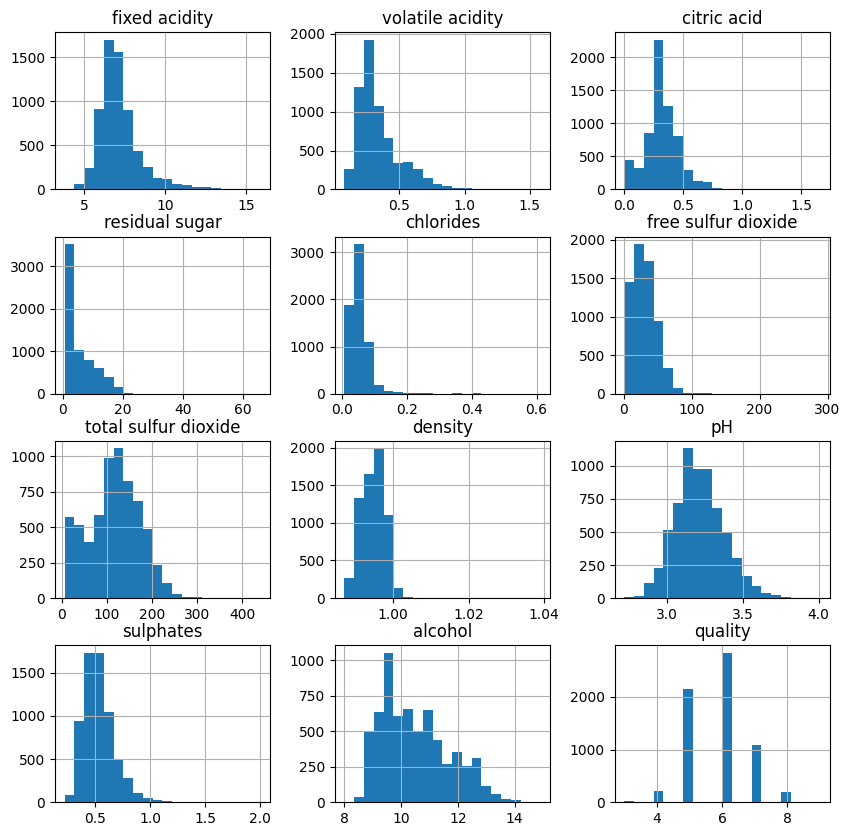

In [99]:
# Get the numerical variables from train_df
numerical_features = [feature for feature in df.columns if df[feature].dtype != object]
print(numerical_features)

df.hist(bins=20, figsize=(10, 10))
plt.show()

In [100]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


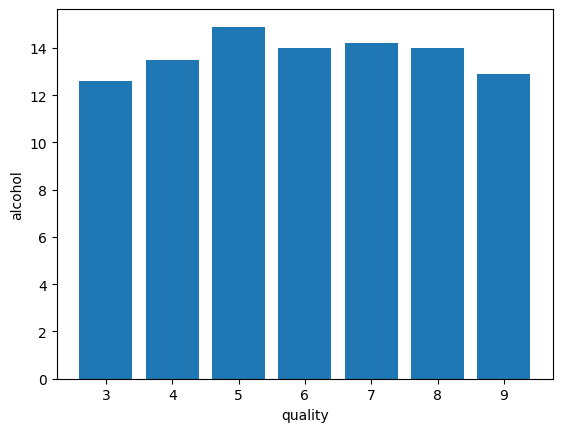

In [101]:
plt.bar(df['quality'], df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()


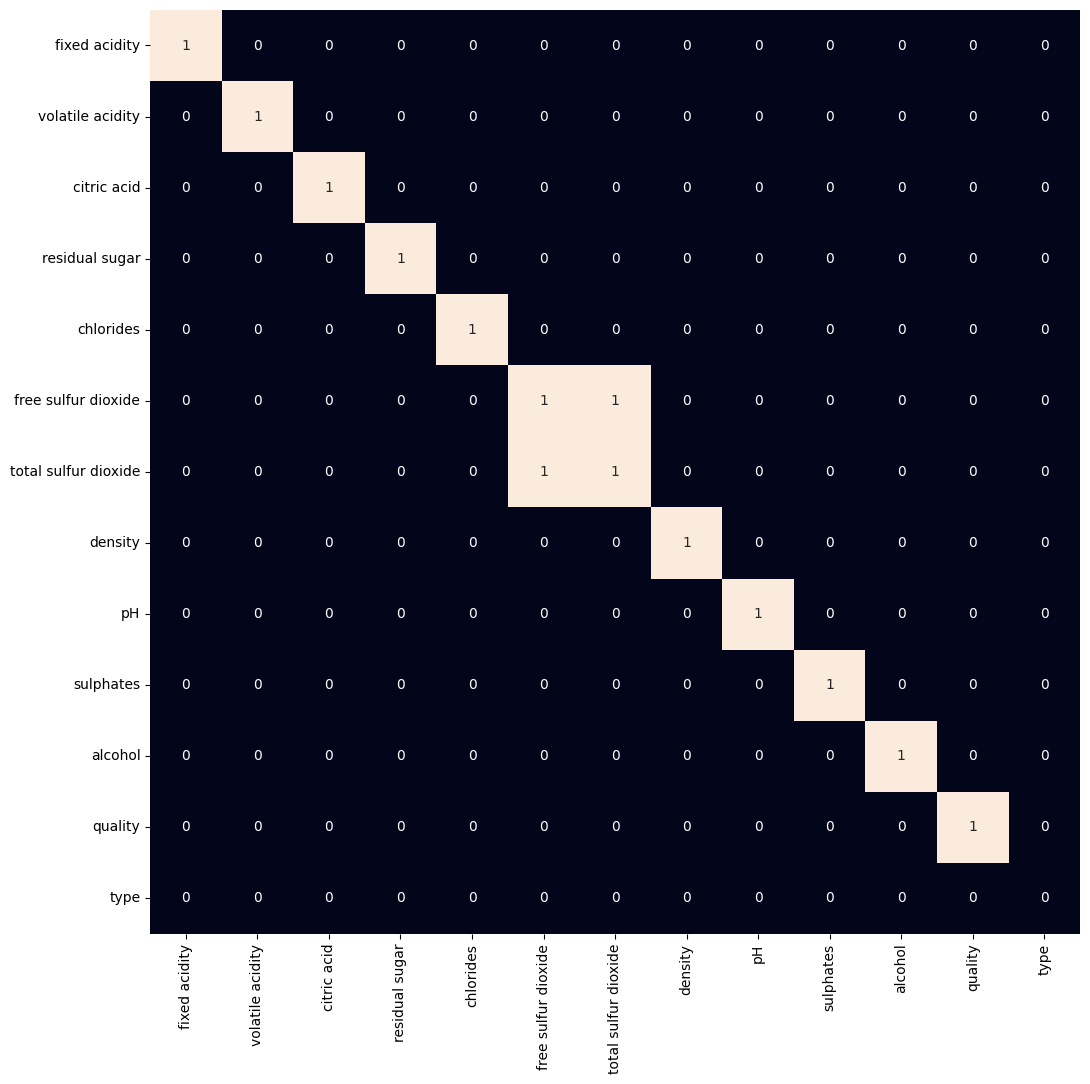

In [102]:
# Convert 'object' columns to numerical if they represent numbers
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace non-convertibles with NaN
        except:
            pass  # Skip columns that cannot be converted

plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [103]:
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]


In [104]:
df.replace({'white': 1, 'red': 0}, inplace=True)

In [107]:
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

xtrain, xtest, ytrain, ytest = train_test_split(
	features, target, test_size=0.2, random_state=40)

# Impute missing values after splitting
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Or another strategy like 'median'
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

xtrain.shape, xtest.shape

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['type']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['type']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


((5197, 11), (1300, 11))

In [109]:
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for i in range(3):
	models[i].fit(xtrain, ytrain)

	print(f'{models[i]} : ')
	print('Training Accuracy : ', metrics.roc_auc_score(ytrain, models[i].predict(xtrain)))
	print('Validation Accuracy : ', metrics.roc_auc_score(
		ytest, models[i].predict(xtest)))
	print()


LogisticRegression() : 
Training Accuracy :  0.7031448777005191
Validation Accuracy :  0.6874115964398881

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9807149516384447
Validation Accuracy :  0.7999136048634141

SVC() : 
Training Accuracy :  0.7491208716092796


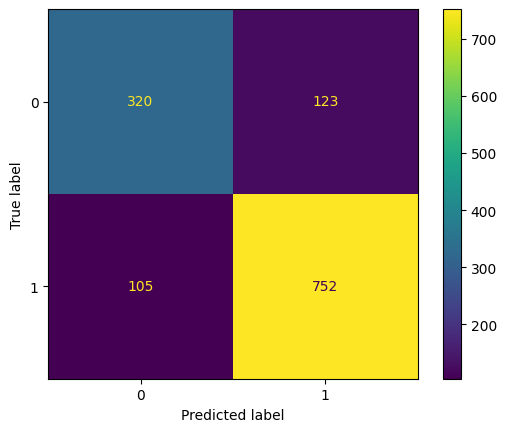

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'models[1]' is your trained classifier
cm = confusion_matrix(ytest, models[1].predict(xtest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[1].classes_) # Assuming your model has a 'classes_' attribute
disp.plot()
plt.show()

In [112]:
print(metrics.classification_report(ytest,
models[1].predict(xtest)))


              precision    recall  f1-score   support

           0       0.75      0.72      0.74       443
           1       0.86      0.88      0.87       857

    accuracy                           0.82      1300
   macro avg       0.81      0.80      0.80      1300
weighted avg       0.82      0.82      0.82      1300

